# Time Series Forecasting - I


> `Flight Delay Prediction:` Prediction of flight delay will help us in managing flight services and operations. This will help us in capacity planning and optimization of time and resources

> In this Notebook we will only try to predict <code style="background:yellow;color:black">total flight delay</code> in coming months


The _objectives_ in the following `Notebook` are:

1. Performing Time Series Modelling using <code style="background:yellow;color:black">Statistical Model</code> by proper analysis and description. 
2. Look for possible insights with the help of __time series data.__
3. Perform EDA for explanation and report the observations for more better clarity

In [29]:
# run the libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,median_absolute_error, mean_squared_error, mean_squared_log_error
warnings.filterwarnings("ignore")
%matplotlib inline

In [30]:
# read the data and see it....
df = pd.read_pickle('Aircraft_Data_Analysis.pkl')
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arriving_delay,carrier_ct,weather_ct,...,arr_diverted,aircraft_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,latitude,longitude,admin_delay
0,2019,1,MQ,Envoy Air,SAV,"Savannah, GA: Savannah/Hilton Head International",65.0,15.01,3.41,0.71,...,1.0,601.0,180.0,29.0,129.0,0.0,263.0,32.140799,-81.204129,129.0
1,2019,1,MQ,Envoy Air,SDF,"Louisville, KY: Louisville Muhammad Ali Intern...",61.0,18.01,2.70,1.01,...,0.0,890.0,180.0,36.0,383.0,0.0,291.0,38.254238,-85.759407,383.0
2,2019,1,MQ,Envoy Air,SGF,"Springfield, MO: Springfield-Branson National",428.0,80.00,13.31,5.18,...,0.0,3954.0,705.0,213.0,982.0,0.0,2054.0,37.216678,-93.292037,982.0
3,2019,1,MQ,Envoy Air,SHV,"Shreveport, LA: Shreveport Regional",174.0,28.01,5.97,1.17,...,0.0,1655.0,360.0,55.0,268.0,0.0,972.0,32.522183,-93.765194,268.0
4,2019,1,MQ,Envoy Air,SJT,"San Angelo, TX: San Angelo Regional/Mathis Field",135.0,23.00,10.78,0.35,...,0.0,835.0,320.0,27.0,192.0,0.0,296.0,31.464836,-100.439844,192.0


## Feature Selection

We need to select features to perform `Time Series Modelling` and use this features to perfrom modelling.

> For each type of model there will be feature engineering done in a seperate way and the reason will be specified.

In [31]:
## set the date and drop it
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df.set_index('date', inplace = True)

The target variable in our case is `aircraft_delay` and we will select it with some other features like `year` , `month` and `airport`

In [32]:
## select the features
df = df[['year','month','airport','aircraft_delay']].sort_index()
df.head()

,year,month,airport,aircraft_delay
date,,,,
2016-03-01,2016,3,OGG,4359.0
2016-03-01,2016,3,SLC,17.0
2016-03-01,2016,3,MEM,808.0
2016-03-01,2016,3,TUS,264.0
2016-03-01,2016,3,COS,218.0


> Converting the __target variable__  into `log` scale for better scaling

In [33]:
## we will try to make it stationary
df['aircraft_delay'] = np.log1p(df['aircraft_delay'])

## Statistical Time Series Model

> We will perfrom time series modelling using `ARIMA` for only predicting total flight delays in a month following the trend curve

Our data in this case needs to be __sampled monthly__ as we have aggregrated data of flight delay based on __Airport__

In [34]:
## selecting only values 'Monthly' as we only have monthly data
df = df[['aircraft_delay']].resample('M').sum()

### EDA & Analysis

- We will perform some EDA and analysis to understand the additive component of data which can be decomposed into trend and seasonality.

- The prime concern for us to make the data stationary as __ARIMA model__ can only be applied to `stationary data.`

- We will also see the effect of the rolling average window and smoothening effect in the data.


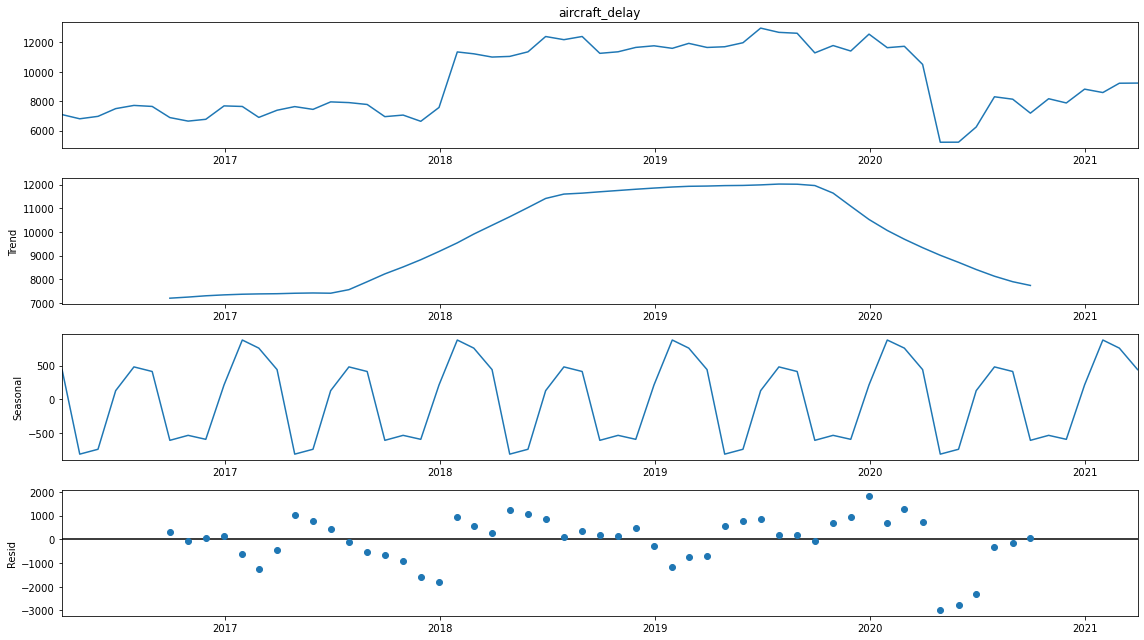

In [35]:
## Lets us decompose the data into additive components
decomposition = sm.tsa.seasonal_decompose(df.aircraft_delay, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

<div class="alert alert-block alert-warning">

__Decomposition__
    
1. There is a seasonality component in the data which needs to be further verified by `Dicky-Fuller test`
    
2. The residual effect leads to a skewed distribution which needs to be properly taken care off.
    
</div>

### Moving Average

Now we will se the effect of __Moving Average__ in the smoothening of data and try to find out the trend in rolling mean in the data

In [36]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
## for ref. 2
moving_average(df,2) # prediction for the last observation interval

9231.305422528389

In [38]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

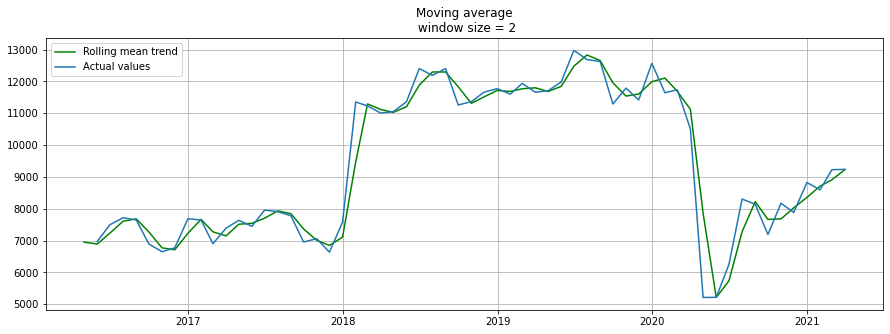

In [39]:
## lets plot moving average
plotMovingAverage(df, 2)

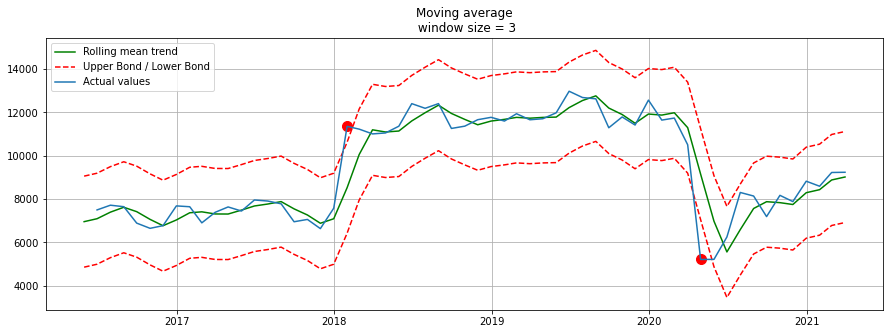

In [40]:
## lets see if any anomalies exist
plotMovingAverage(df, 3, plot_intervals=True, plot_anomalies=True)

<div class="alert alert-block alert-warning">

__Moving Average__
    
1. The rolling mean window needs to be set high for smoothening of data. The upper trend value and lower trend value also confirms it.
    
2. Due to low number of data points this cannot be done as we have restricted number of points in our data.
    
</div>

### Exponential Smoothing

Instead of weighting the last  'k'  values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$
y_t = \alpha * y_t + (1 - \alpha) * y_{t -1}
$$

In [41]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [42]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

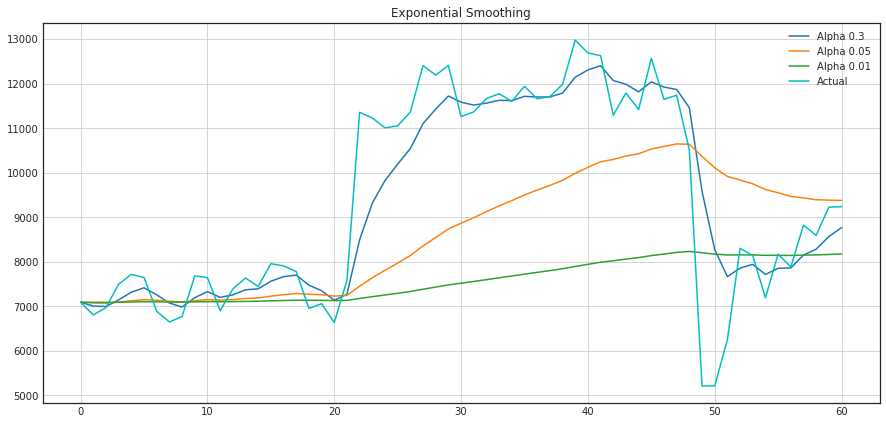

In [43]:
## let us plot with various scales of smoothing
plotExponentialSmoothing(df.aircraft_delay, [0.3, 0.05, 0.01])

> We observe that with decreasing alpha values we get more flattened curve which tells us that over a period of time the delay values do have some `impact` with previous values

## Time Series Modelling

Now we will move towards ARIMA model. But before doing it we need to check for __stationarity__ of our data. For doing this we will use __'Dicky-Fuller'__ test

In [44]:
### Test for stationary

def ad_test(dataset,significance=0.05):
     '''
     This function takes input as data and check for stationary
     '''
     ## let us get the test result
     dftest = adfuller(dataset, autolag = 'AIC')
        
     ## print the values
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
        
     if dftest[1] <= significance:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
     else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
def metric_calc(forecast, actual, model_name=None):
        '''
        This calculates the accuracy metrics gives our predicted and test data
        '''
        # Calculate metrics and append it
        mae  = metrics.mean_absolute_error(actual,forecast)
        mape = metrics.mean_absolute_percentage_error(actual,forecast)
        mse  = metrics.mean_squared_error(actual,forecast)
        rmse = np.sqrt(metrics.mean_squared_error(actual,forecast))
        r2   = metrics.r2_score(actual,forecast)
        
        if model_name:
            print(colored("The results of your {} are :".format(model_name),color = 'yellow', attrs=['bold']))
        # print the metrics
        print('Mean Absolute Error:', mae)
        print('Mean Absolute Percentage Error:', mape)
        print('Mean Squared Error:',  mse)
        print('Root Mean Squared Error:', rmse)
        print('R Squared:', r2)     

In [45]:
## lets check for stationarity
ad_test(df.aircraft_delay)

1. ADF :  -1.9319363823182898
2. P-Value :  0.31718954482987494
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 




<div class="alert alert-block alert-danger">
    
<b>Stationary:</b>
Our data is non-stationary and needs to be made stationary. For this purpose we will take first order difference
    
> We can't do seasonal difference as we lack data points to do it.
    
</div>

In [46]:
## take the difference and check for stationarity
value = np.diff(df['aircraft_delay'])

## Lets do the test again
ad_test(value,significance=0.01)

1. ADF :  -6.855302811109925
2. P-Value :  1.654304371965906e-09
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


__Some Facts__:

1. __Identification of an AR model is often best done with the PACF:__
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.


2. __Identification of an MA model is often best done with the ACF rather than the PACF:__
For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

>Since, we are trying to develop an ARIMA model we want values `p,d,q`
- p : AR Model Lags
- d : Differencing
- q : MA Model Lags

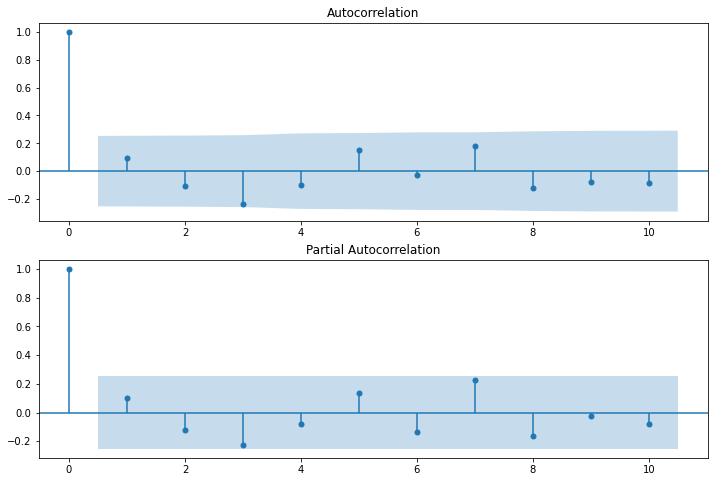

In [47]:
## plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(value,lags=10,ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(value,lags=10,ax=ax2)


> PACF shows significant coorelation at Lag 3 so our `p = 2`

> ACF shows significant value at Lag 1 so our `q = 2`

In [72]:
## ARIMA value with p = 2, d = 0, q = 2
model    =ARIMA(df['aircraft_delay'],order=(2,0,2))
model_fit= model.fit()

In [73]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         aircraft_delay   No. Observations:                   61
Model:                     ARMA(2, 2)   Log Likelihood                -508.648
Method:                       css-mle   S.D. of innovations            998.204
Date:                Sun, 06 Jun 2021   AIC                           1029.296
Time:                        23:03:24   BIC                           1041.961
Sample:                    03-31-2016   HQIC                          1034.259
                         - 03-31-2021                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 9190.6487    888.681     10.342      0.000    7448.865    1.09e+04
ar.L1.aircraft_delay     0.5274      0.455      1.159      0.246      -0.364       1.419
ar.L2.aircraft_delay     0.2440      0.387      0.631      0.528      -0.514       1.002
ma.L1.aircraft_delay     0.5252      0.451      1.165      0.244      -0.359       1.409
ma.L2.aircraft_delay     0.1804      0.231      0.781      0.435      -0.272       0.633
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2141           +0.0000j            1.2141            0.0000
AR.2           -3.3759           +0.0000j            3.3759            0.5000
MA.1           -1.4554           -1.8504j            2.3542           -0.3561
MA.2           -1.4554           +1.8504j            2.3542            0.3561
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date'>

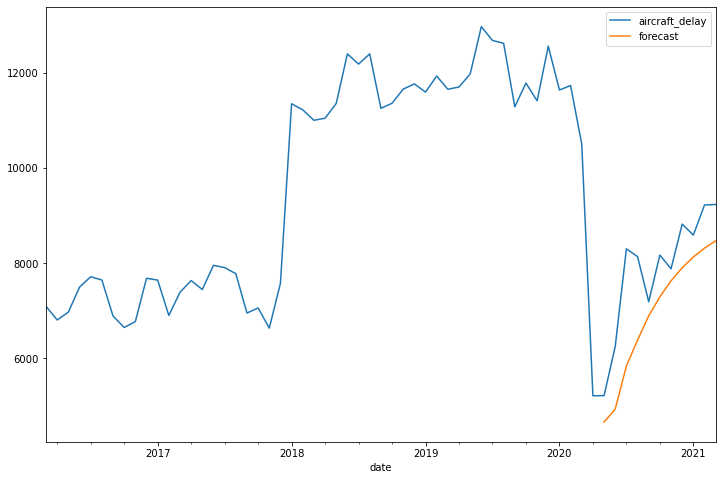

In [74]:
df['forecast']=model_fit.predict(start=50,end=65,dynamic=True)
df[['aircraft_delay','forecast']].plot(figsize=(12,8))

In [75]:
## Let us calculate the metric for some of our data points
metric_calc(df['aircraft_delay'][50:],df['forecast'][50:], model_name=None)

Mean Absolute Error: 961.3848580058348
Mean Absolute Percentage Error: 0.15024159892798733
Mean Squared Error: 1326534.5286884801
Root Mean Squared Error: 1151.7528071111788
R Squared: 0.18708931061051415


<AxesSubplot:ylabel='Density'>

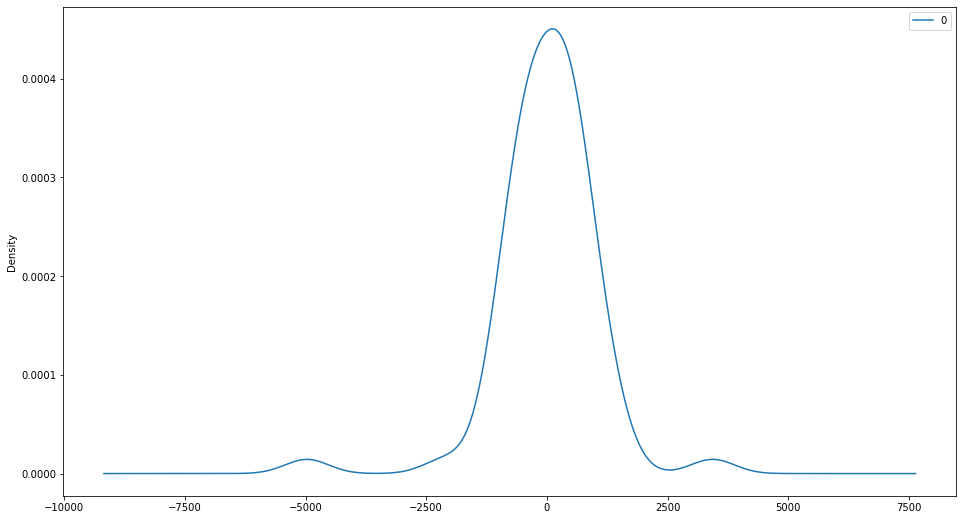

In [60]:
## plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

<div class="alert alert-block alert-warning">

__Modelling:__
    
1. The modelling taking first order difference yields very poor results and our predicted line closely <code style="background:yellow;color:black">resembles to the mean value.</code>
    
2. However we do acheive a considerable `MAPE` value and our residuals almost __normally distributed.__  
    
</div>

__Curious With Prophet__

Let us see with Prophet what is the outcome on our total dataset...

In [61]:
## load and instantiate
from fbprophet import Prophet
m = Prophet()

In [62]:
## preparing the data into proper format for prophet
f = pd.DataFrame({"ds" : df.index, "y" : df['aircraft_delay']}).reset_index(drop=True)

In [63]:
## running the prophet model
m.fit(f)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
68,2021-11-01,10884.429958,7707.673610,12833.360761,10883.710384,10885.237401,-568.232701,-568.232701,-568.232701,-568.232701,-568.232701,-568.232701,0.0,0.0,0.0,10316.197257
69,2021-12-01,10920.241808,6551.287482,11775.666130,10919.333769,10921.224397,-1839.915681,-1839.915681,-1839.915681,-1839.915681,-1839.915681,-1839.915681,0.0,0.0,0.0,9080.326126
70,2022-01-01,10957.247386,6345.804708,11635.391682,10956.122753,10958.452747,-1988.331265,-1988.331265,-1988.331265,-1988.331265,-1988.331265,-1988.331265,0.0,0.0,0.0,8968.916121
71,2022-02-01,10994.252964,8359.840683,13532.372783,10992.889293,10995.679174,-6.310494,-6.310494,-6.310494,-6.310494,-6.310494,-6.310494,0.0,0.0,0.0,10987.942469
72,2022-03-01,11027.677357,11321.743027,16612.368481,11026.108178,11029.274697,2930.378357,2930.378357,2930.378357,2930.378357,2930.378357,2930.378357,0.0,0.0,0.0,13958.055714


<AxesSubplot:xlabel='date'>

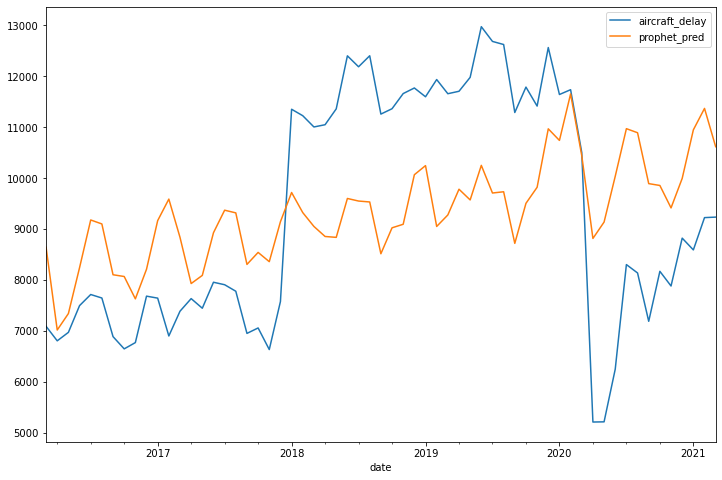

In [64]:
## let us see now
df['prophet_pred'] = prophet_pred['yhat'][:len(df)].values
df[['aircraft_delay','prophet_pred']].plot(figsize=(12,8))

In [65]:
## Let us calculate the metric for some of our data points
metric_calc(df['aircraft_delay'],df['prophet_pred'], model_name=None)

Mean Absolute Error: 1848.6021248986378
Mean Absolute Percentage Error: 0.1967806241534117
Mean Squared Error: 4212449.186147768
Root Mean Squared Error: 2052.425196236825
R Squared: -3.5200675559938963


> MAPE value is quite low using this model but its usage remains a question as the architecture is still not clear...

<div class="alert alert-block alert-success">
<b>Success:</b> Since we are now able to predict the delay in flights lets now try to predict flight delay airport wise...
</div>